# Limit Opinion Consensus Check for Symmetric Case, Circle Network and Clique Network

#### Unified Model with Multiple Strategic Agents
#### Strategic Agent-Specific Message Weights

James Yu, 20 January 2023, revised 24 February 2023, updated 31 May 2024, updated 10 June 2024

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(np.finfo(np.float64).eps)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, b1, b2, a1, a2, delta = 0.8, c = 1, X_0_1 = np.array([[10.0, 0.0, 0.0, 0.0]], ndmin = 2).T, symmetric = True, print_ = True, tol = np.sqrt(np.finfo(np.float64).eps)):
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 4 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, rs, payoffs = optimal(X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)
    print("Network:")
    print(A)
    print("Steady-State Opinions:")
    print(xs[0][-1] + b1)
    print("Steady-State Messages:")
    print("1", rs[0][-1])
    print("2", rs[1][-1])
    print("Total Payoffs:")
    print("1", payoffs[0][-1])
    print("2", payoffs[1][-1])
    print("Average of agendas:")
    print((b1+b2)/2)
    print()
    print("K^* (1, 2):")
    print(K_ss[0])
    print(K_ss[1])
    print()
    print("k^* (1, 2):")
    print(k_ss[0])
    print(k_ss[1])
    print()
    print("kappa^* (1, 2):")
    print(kappa_ss[0])
    print(kappa_ss[1])
    return xs, rs, payoffs

In [7]:
A_1 = np.array([
    [1/3, 1/3, 0, 1/3],
    [1/3, 1/3, 1/3, 0],
    [0, 1/3, 1/3, 1/3],
    [1/3, 0, 1/3, 1/3],
])

A_2 = np.array([
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
])

### Case 1: Equal $\alpha$, same agenda

In [8]:
xs_1_1, rs_1_1, payoffs_1_1 = run_simulation(A_1, 0, 0, 1, 1) #b1, b2 agendas, followed by alpha_1, alpha_2 weights

Network:
[[0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]
Steady-State Opinions:
[[2.88189227e-09]
 [2.88189227e-09]
 [2.88189218e-09]
 [2.88189227e-09]]
Steady-State Messages:
1 [[-2.81584755e-09]
 [-2.81584755e-09]
 [-2.81584748e-09]
 [-2.81584755e-09]]
2 [[-2.81584755e-09]
 [-2.81584755e-09]
 [-2.81584748e-09]
 [-2.81584755e-09]]
Total Payoffs:
1 -107.31781550730979
2 -107.31781550730979
Average of agendas:
0.0

K^* (1, 2):
[[1.07317816 0.04939181 0.04939181 0.04939181]
 [0.04939181 1.07317816 0.04939181 0.04939181]
 [0.04939181 0.04939181 1.07317816 0.04939181]
 [0.04939181 0.04939181 0.04939181 1.07317816]]
[[1.07317816 0.04939181 0.04939181 0.04939181]
 [0.04939181 1.07317816 0.04939181 0.04939181]
 [0.04939181 0.04939181 1.07317816 0.04939181]
 [0.04939181 0.04939181 0.04939181 1.07317816]]

k^* (1, 2):
[[0. 0. 0. 0.]]
[[0. 0. 0. 0.]]

kappa

In [9]:
xs_1_2, rs_1_2, payoffs_1_2 = run_simulation(A_2, 0, 0, 1, 1)

Network:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Steady-State Opinions:
[[2.88189224e-09]
 [2.88189224e-09]
 [2.88189224e-09]
 [2.88189224e-09]]
Steady-State Messages:
1 [[-2.81584754e-09]
 [-2.81584754e-09]
 [-2.81584754e-09]
 [-2.81584754e-09]]
2 [[-2.81584754e-09]
 [-2.81584754e-09]
 [-2.81584754e-09]
 [-2.81584754e-09]]
Total Payoffs:
1 -105.53383959797424
2 -105.53383959797424
Average of agendas:
0.0

K^* (1, 2):
[[1.0553384 0.0553384 0.0553384 0.0553384]
 [0.0553384 1.0553384 0.0553384 0.0553384]
 [0.0553384 0.0553384 1.0553384 0.0553384]
 [0.0553384 0.0553384 0.0553384 1.0553384]]
[[1.0553384 0.0553384 0.0553384 0.0553384]
 [0.0553384 1.0553384 0.0553384 0.0553384]
 [0.0553384 0.0553384 1.0553384 0.0553384]
 [0.0553384 0.0553384 0.0553384 1.0553384]]

k^* (1, 2):
[[0. 0. 0. 0.]]
[[0. 0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


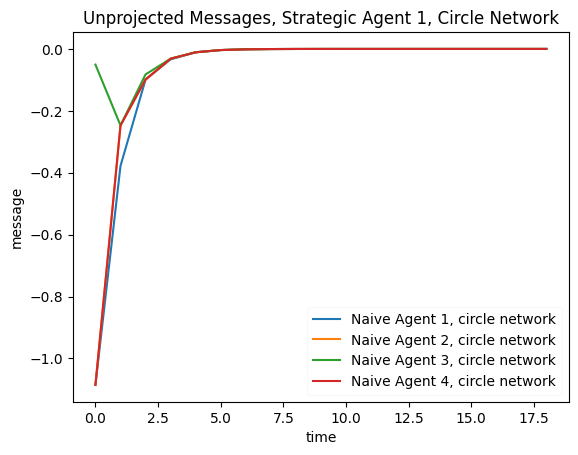

In [10]:
for i in range(4):
    plt.plot(range(len(rs_1_1[0])), [rs_1_1[0][j][i].item() for j in range(len(rs_1_1[0]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 1, Circle Network")
plt.show()

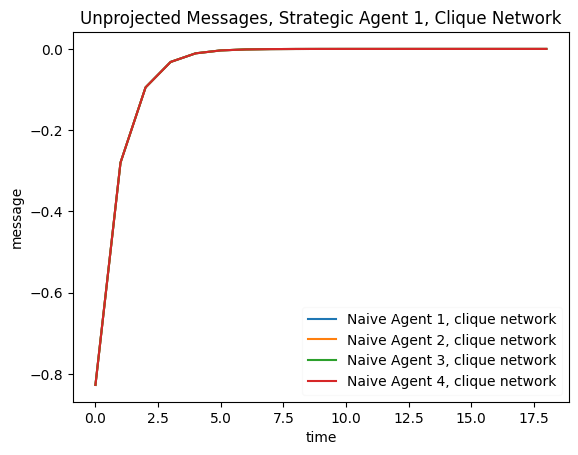

In [11]:
for i in range(4):
    plt.plot(range(len(rs_1_2[0])), [rs_1_2[0][j][i].item() for j in range(len(rs_1_2[0]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 1, Clique Network")
plt.show()

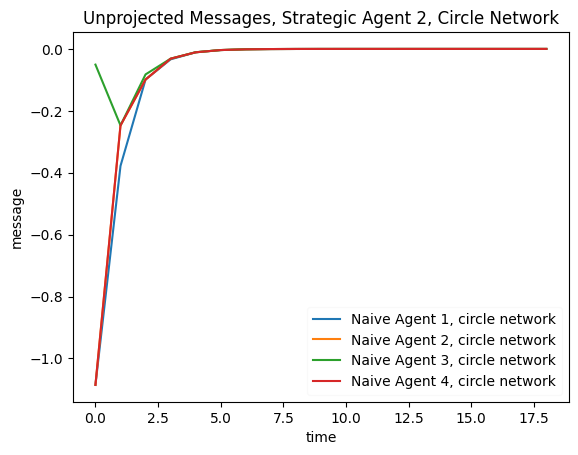

In [12]:
for i in range(4):
    plt.plot(range(len(rs_1_1[1])), [rs_1_1[1][j][i].item() for j in range(len(rs_1_1[1]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 2, Circle Network")
plt.show()

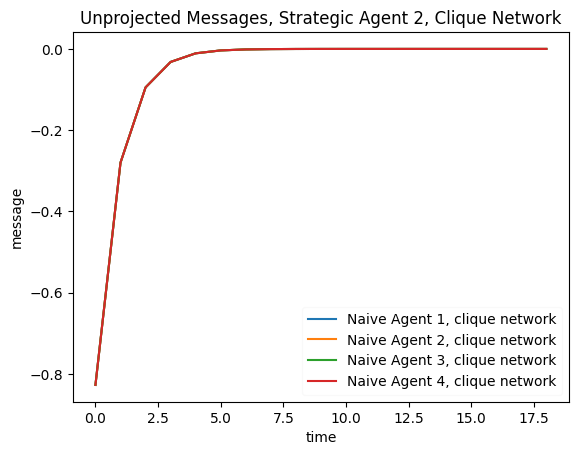

In [13]:
for i in range(4):
    plt.plot(range(len(rs_1_2[1])), [rs_1_2[1][j][i].item() for j in range(len(rs_1_2[1]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 2, Clique Network")
plt.show()

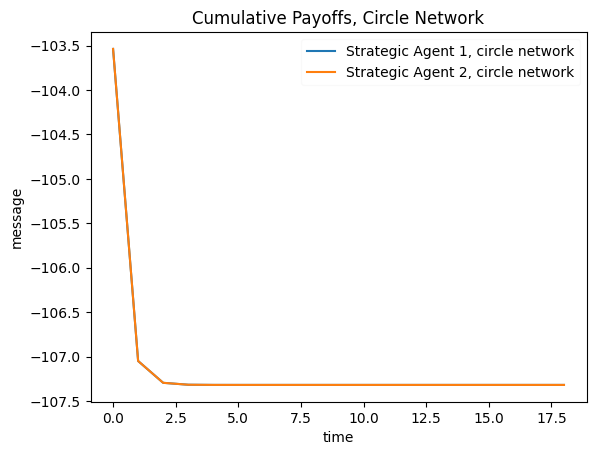

In [14]:
plt.plot(range(len(payoffs_1_1[0])), [payoffs_1_1[0][j] for j in range(len(payoffs_1_1[0]))], label = f"Strategic Agent 1, circle network")
plt.plot(range(len(payoffs_1_1[1])), [payoffs_1_1[1][j] for j in range(len(payoffs_1_1[1]))], label = f"Strategic Agent 2, circle network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Circle Network")
plt.show()

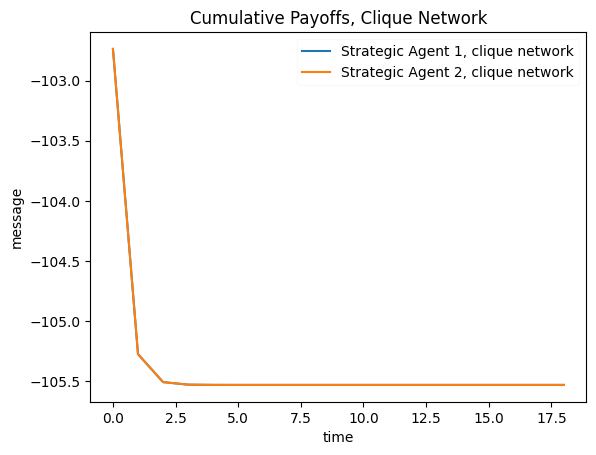

In [15]:
plt.plot(range(len(payoffs_1_2[0])), [payoffs_1_2[0][j] for j in range(len(payoffs_1_2[0]))], label = f"Strategic Agent 1, clique network")
plt.plot(range(len(payoffs_1_2[1])), [payoffs_1_2[1][j] for j in range(len(payoffs_1_2[1]))], label = f"Strategic Agent 2, clique network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

### Case 2: Equal $\alpha$, different agendas

In [16]:
xs_2_1, rs_2_1, payoffs_2_1 = run_simulation(A_1, 0, 10, 1, 1)

Network:
[[0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]
Steady-State Opinions:
[[4.99999997]
 [4.99999997]
 [4.99999997]
 [4.99999997]]
Steady-State Messages:
1 [[-8.60959397]
 [-8.60959397]
 [-8.60959397]
 [-8.60959397]]
2 [[8.60959402]
 [8.60959402]
 [8.60959402]
 [8.60959402]]
Total Payoffs:
1 -1829.9381595482519
2 -2260.4178590370243
Average of agendas:
5.0

K^* (1, 2):
[[1.07317816 0.04939181 0.04939181 0.04939181]
 [0.04939181 1.07317816 0.04939181 0.04939181]
 [0.04939181 0.04939181 1.07317816 0.04939181]
 [0.04939181 0.04939181 0.04939181 1.07317816]]
[[1.07317816 0.04939181 0.04939181 0.04939181]
 [0.04939181 1.07317816 0.04939181 0.04939181]
 [0.04939181 0.04939181 1.07317816 0.04939181]
 [0.04939181 0.04939181 0.04939181 1.07317816]]

k^* (1, 2):
[[9.31044914 9.31044914 9.31044914 9.31044914]]
[[-9.31044914 -9.31044914 -9.31044914 -9.3

In [17]:
xs_2_2, rs_2_2, payoffs_2_2 = run_simulation(A_2, 0, 10, 1, 1)

Network:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Steady-State Opinions:
[[4.99999997]
 [4.99999997]
 [4.99999997]
 [4.99999997]]
Steady-State Messages:
1 [[-8.60959397]
 [-8.60959397]
 [-8.60959397]
 [-8.60959397]]
2 [[8.60959402]
 [8.60959402]
 [8.60959402]
 [8.60959402]]
Total Payoffs:
1 -1828.1541836389151
2 -2258.633883127687
Average of agendas:
5.0

K^* (1, 2):
[[1.0553384 0.0553384 0.0553384 0.0553384]
 [0.0553384 1.0553384 0.0553384 0.0553384]
 [0.0553384 0.0553384 1.0553384 0.0553384]
 [0.0553384 0.0553384 0.0553384 1.0553384]]
[[1.0553384 0.0553384 0.0553384 0.0553384]
 [0.0553384 1.0553384 0.0553384 0.0553384]
 [0.0553384 0.0553384 1.0553384 0.0553384]
 [0.0553384 0.0553384 0.0553384 1.0553384]]

k^* (1, 2):
[[9.31044914 9.31044914 9.31044914 9.31044914]]
[[-9.31044914 -9.31044914 -9.31044914 -9.31044914]]

kappa^* (1, 2):
[[-1674.15775293]]
[[-1674.15775293]]


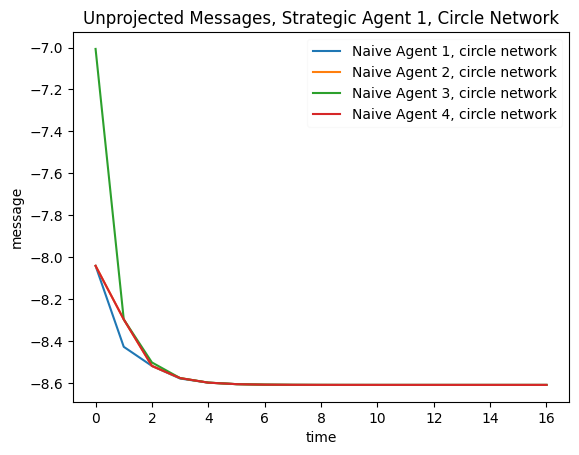

In [18]:
for i in range(4):
    plt.plot(range(len(rs_2_1[0])), [rs_2_1[0][j][i].item() for j in range(len(rs_2_1[0]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 1, Circle Network")
plt.show()

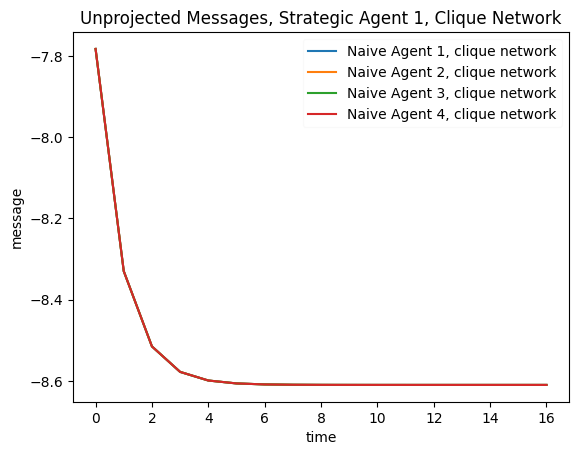

In [19]:
for i in range(4):
    plt.plot(range(len(rs_2_2[0])), [rs_2_2[0][j][i].item() for j in range(len(rs_2_2[0]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 1, Clique Network")
plt.show()

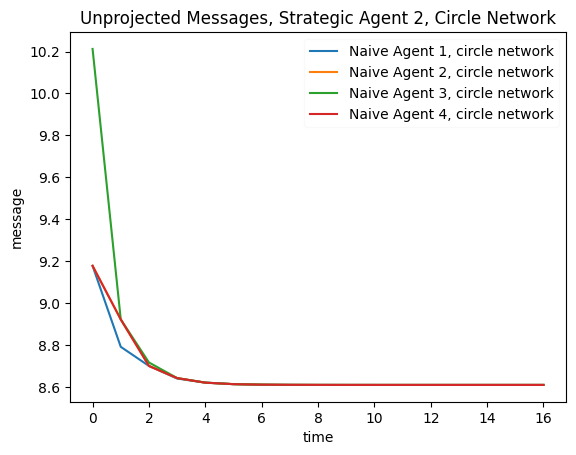

In [20]:
for i in range(4):
    plt.plot(range(len(rs_2_1[1])), [rs_2_1[1][j][i].item() for j in range(len(rs_2_1[1]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 2, Circle Network")
plt.show()

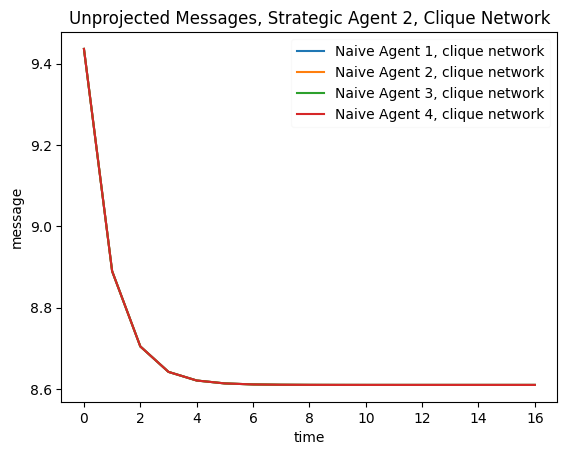

In [21]:
for i in range(4):
    plt.plot(range(len(rs_2_2[1])), [rs_2_2[1][j][i].item() for j in range(len(rs_2_2[1]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 2, Clique Network")
plt.show()

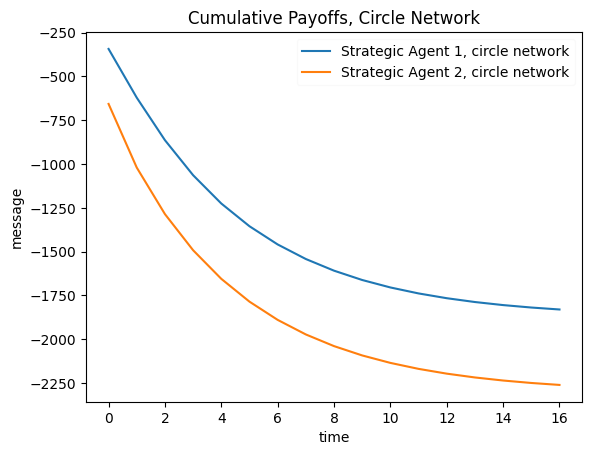

In [22]:
plt.plot(range(len(payoffs_2_1[0])), [payoffs_2_1[0][j] for j in range(len(payoffs_2_1[0]))], label = f"Strategic Agent 1, circle network")
plt.plot(range(len(payoffs_2_1[1])), [payoffs_2_1[1][j] for j in range(len(payoffs_2_1[1]))], label = f"Strategic Agent 2, circle network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Circle Network")
plt.show()

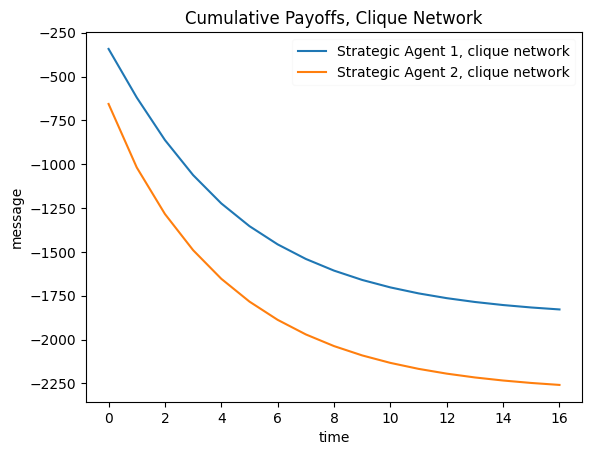

In [23]:
plt.plot(range(len(payoffs_2_2[0])), [payoffs_2_2[0][j] for j in range(len(payoffs_2_2[0]))], label = f"Strategic Agent 1, clique network")
plt.plot(range(len(payoffs_2_2[1])), [payoffs_2_2[1][j] for j in range(len(payoffs_2_2[1]))], label = f"Strategic Agent 2, clique network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

### Case 3: Different $\alpha$, same agenda

In [24]:
xs_3_1, rs_3_1, payoffs_3_1 = run_simulation(A_1, 0, 0, 0.5, 1)

Network:
[[0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]
Steady-State Opinions:
[[5.09856951e-09]
 [5.09856951e-09]
 [5.09856950e-09]
 [5.09856951e-09]]
Steady-State Messages:
1 [[-2.47030851e-09]
 [-2.47030851e-09]
 [-2.47030850e-09]
 [-2.47030851e-09]]
2 [[-5.83642279e-09]
 [-5.83642279e-09]
 [-5.83642279e-09]
 [-5.83642279e-09]]
Total Payoffs:
1 -107.26780878058915
2 -113.83424113973724
Average of agendas:
0.0

K^* (1, 2):
[[1.07267809 0.04619907 0.04619907 0.04619907]
 [0.04619907 1.07267809 0.04619907 0.04619907]
 [0.04619907 0.04619907 1.07267809 0.04619907]
 [0.04619907 0.04619907 0.04619907 1.07267809]]
[[1.13834241 0.09751824 0.09751824 0.09751824]
 [0.09751824 1.13834241 0.09751824 0.09751824]
 [0.09751824 0.09751824 1.13834241 0.09751824]
 [0.09751824 0.09751824 0.09751824 1.13834241]]

k^* (1, 2):
[[0. 0. 0. 0.]]
[[0. 0. 0. 0.]]

kappa

In [25]:
xs_3_2, rs_3_2, payoffs_3_2 = run_simulation(A_2, 0, 0, 0.5, 1)

Network:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Steady-State Opinions:
[[5.09856951e-09]
 [5.09856951e-09]
 [5.09856951e-09]
 [5.09856951e-09]]
Steady-State Messages:
1 [[-2.47030851e-09]
 [-2.47030851e-09]
 [-2.47030851e-09]
 [-2.47030851e-09]]
2 [[-5.83642279e-09]
 [-5.83642279e-09]
 [-5.83642279e-09]
 [-5.83642279e-09]]
Total Payoffs:
1 -105.281882034724
2 -110.77242849120428
Average of agendas:
0.0

K^* (1, 2):
[[1.05281882 0.05281882 0.05281882 0.05281882]
 [0.05281882 1.05281882 0.05281882 0.05281882]
 [0.05281882 0.05281882 1.05281882 0.05281882]
 [0.05281882 0.05281882 0.05281882 1.05281882]]
[[1.10772428 0.10772428 0.10772428 0.10772428]
 [0.10772428 1.10772428 0.10772428 0.10772428]
 [0.10772428 0.10772428 1.10772428 0.10772428]
 [0.10772428 0.10772428 0.10772428 1.10772428]]

k^* (1, 2):
[[0. 0. 0. 0.]]
[[0. 0. 0. 0.]]

kappa^* (1, 2):
[[-0.]]
[[-0.]]


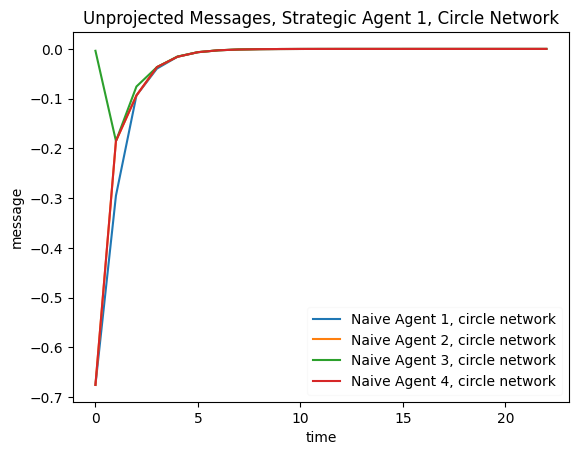

In [26]:
for i in range(4):
    plt.plot(range(len(rs_3_1[0])), [rs_3_1[0][j][i].item() for j in range(len(rs_3_1[0]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 1, Circle Network")
plt.show()

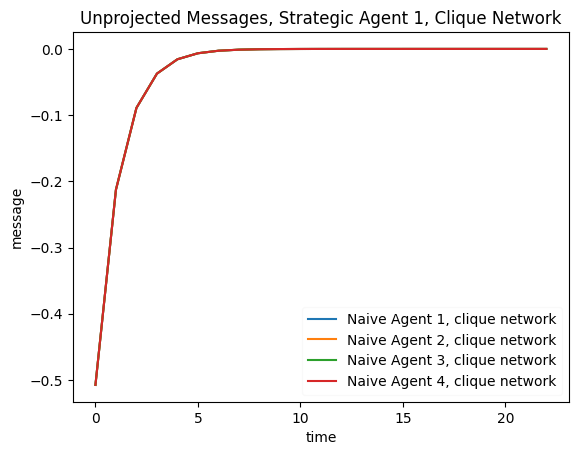

In [27]:
for i in range(4):
    plt.plot(range(len(rs_3_2[0])), [rs_3_2[0][j][i].item() for j in range(len(rs_3_2[0]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 1, Clique Network")
plt.show()

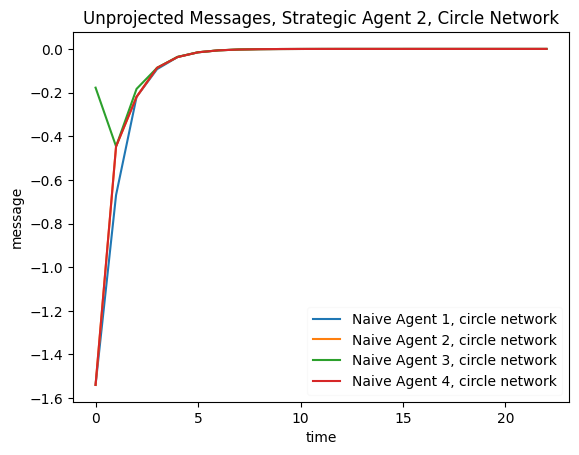

In [28]:
for i in range(4):
    plt.plot(range(len(rs_3_1[1])), [rs_3_1[1][j][i].item() for j in range(len(rs_3_1[1]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 2, Circle Network")
plt.show()

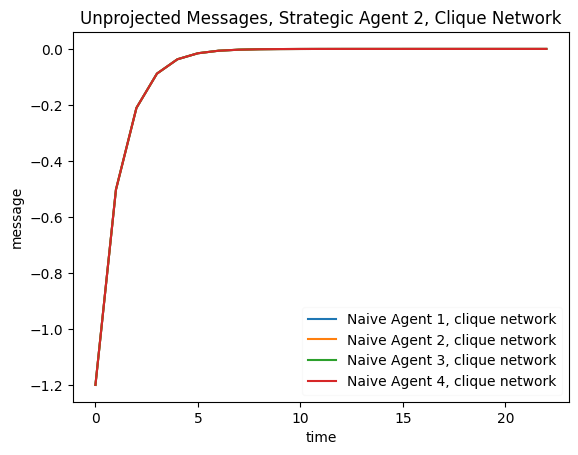

In [29]:
for i in range(4):
    plt.plot(range(len(rs_3_2[1])), [rs_3_2[1][j][i].item() for j in range(len(rs_3_2[1]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Unprojected Messages, Strategic Agent 2, Clique Network")
plt.show()

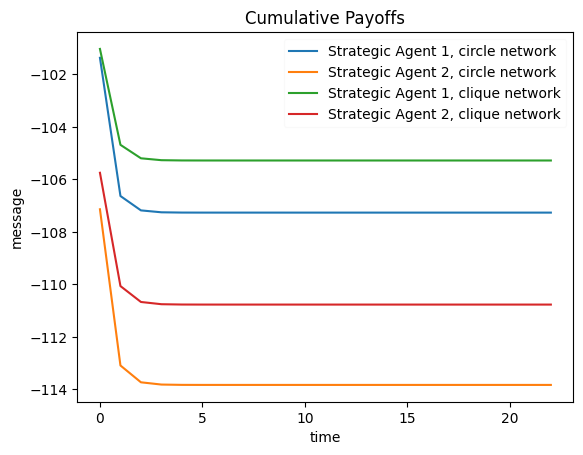

In [30]:
plt.plot(range(len(payoffs_3_1[0])), [payoffs_3_1[0][j] for j in range(len(payoffs_3_1[0]))], label = f"Strategic Agent 1, circle network")
plt.plot(range(len(payoffs_3_1[1])), [payoffs_3_1[1][j] for j in range(len(payoffs_3_1[1]))], label = f"Strategic Agent 2, circle network")
plt.plot(range(len(payoffs_3_2[0])), [payoffs_3_2[0][j] for j in range(len(payoffs_3_2[0]))], label = f"Strategic Agent 1, clique network")
plt.plot(range(len(payoffs_3_2[1])), [payoffs_3_2[1][j] for j in range(len(payoffs_3_2[1]))], label = f"Strategic Agent 2, clique network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs")
plt.show()

### Case 4: Different $\alpha$, different agenda

In [31]:
xs_4_1, rs_4_1, payoffs_4_1 = run_simulation(A_1, 0, 10, 0.5, 1)

Network:
[[0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]
Steady-State Opinions:
[[8.9250285]
 [8.9250285]
 [8.9250285]
 [8.9250285]]
Steady-State Messages:
1 [[-6.11664607]
 [-6.11664607]
 [-6.11664607]
 [-6.11664607]]
2 [[3.05832305]
 [3.05832305]
 [3.05832305]
 [3.05832305]]
Total Payoffs:
1 -1818.572732106752
2 -719.7727475799245
Average of agendas:
5.0

K^* (1, 2):
[[1.07267809 0.04619906 0.04619906 0.04619906]
 [0.04619906 1.07267809 0.04619906 0.04619906]
 [0.04619906 0.04619906 1.07267809 0.04619906]
 [0.04619906 0.04619906 0.04619906 1.07267809]]
[[1.13834241 0.09751824 0.09751824 0.09751824]
 [0.09751824 1.13834241 0.09751824 0.09751824]
 [0.09751824 0.09751824 1.13834241 0.09751824]
 [0.09751824 0.09751824 0.09751824 1.13834241]]

k^* (1, 2):
[[8.96189756 8.96189756 8.96189756 8.96189756]]
[[-4.56946033 -4.56946033 -4.56946033 -4.5694603

In [32]:
xs_4_2, rs_4_2, payoffs_4_2 = run_simulation(A_2, 0, 10, 0.5, 1)

Network:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Steady-State Opinions:
[[8.9250285]
 [8.9250285]
 [8.9250285]
 [8.9250285]]
Steady-State Messages:
1 [[-6.11664607]
 [-6.11664607]
 [-6.11664607]
 [-6.11664607]]
2 [[3.05832305]
 [3.05832305]
 [3.05832305]
 [3.05832305]]
Total Payoffs:
1 -1816.5868053608867
2 -716.7109349313913
Average of agendas:
5.0

K^* (1, 2):
[[1.05281882 0.05281882 0.05281882 0.05281882]
 [0.05281882 1.05281882 0.05281882 0.05281882]
 [0.05281882 0.05281882 1.05281882 0.05281882]
 [0.05281882 0.05281882 0.05281882 1.05281882]]
[[1.10772429 0.10772429 0.10772429 0.10772429]
 [0.10772429 1.10772429 0.10772429 0.10772429]
 [0.10772429 0.10772429 1.10772429 0.10772429]
 [0.10772429 0.10772429 0.10772429 1.10772429]]

k^* (1, 2):
[[8.96189756 8.96189756 8.96189756 8.96189756]]
[[-4.56946033 -4.56946033 -4.56946033 -4.56946033]]

kappa^* (1, 2):
[[-1635.50698712]]
[[-183.91593047]]


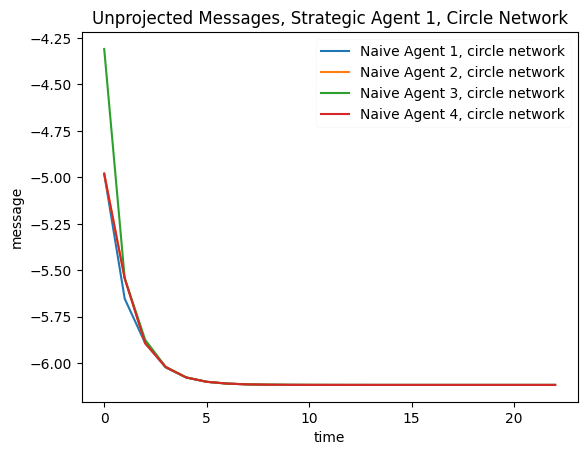

In [33]:
for i in range(4):
    plt.plot(range(len(rs_4_1[0])), [rs_4_1[0][j][i].item() for j in range(len(rs_4_1[0]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 1, Circle Network")
plt.show()

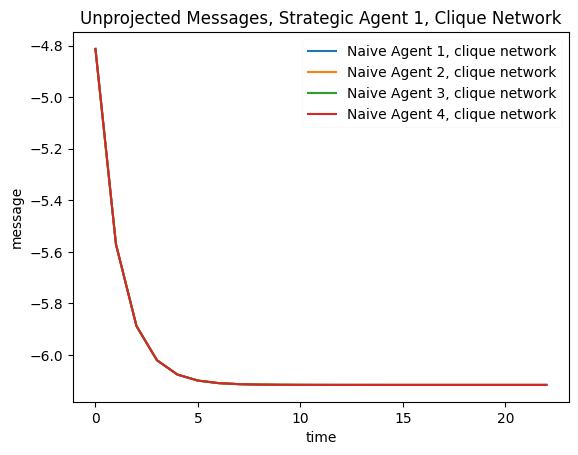

In [34]:
for i in range(4):
    plt.plot(range(len(rs_4_2[0])), [rs_4_2[0][j][i].item() for j in range(len(rs_4_2[0]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 1, Clique Network")
plt.show()

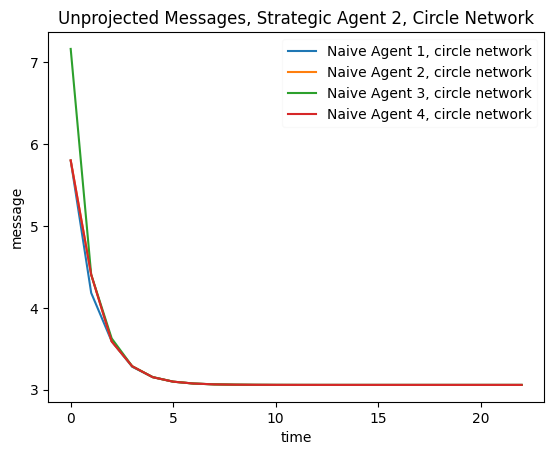

In [35]:
for i in range(4):
    plt.plot(range(len(rs_4_1[1])), [rs_4_1[1][j][i].item() for j in range(len(rs_4_1[1]))], label = f"Naive Agent {i+1}, circle network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 2, Circle Network")
plt.show()

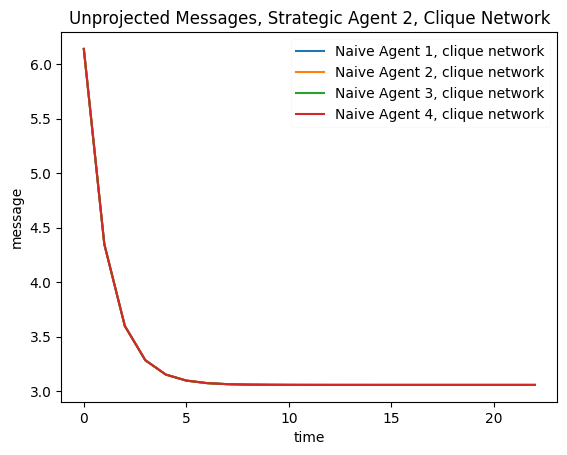

In [36]:
for i in range(4):
    plt.plot(range(len(rs_4_2[1])), [rs_4_2[1][j][i].item() for j in range(len(rs_4_2[1]))], label = f"Naive Agent {i+1}, clique network")
    
plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Unprojected Messages, Strategic Agent 2, Clique Network")
plt.show()

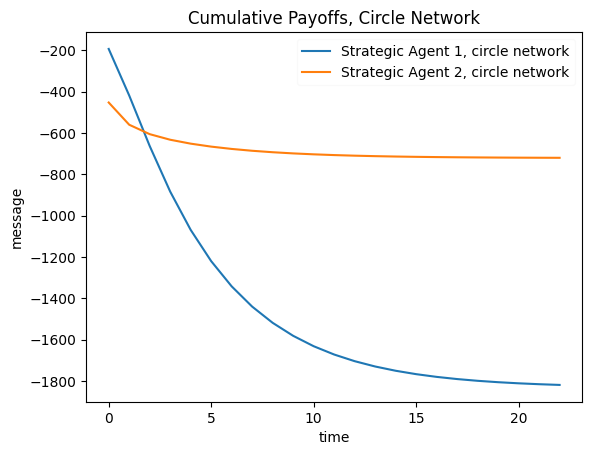

In [37]:
plt.plot(range(len(payoffs_4_1[0])), [payoffs_4_1[0][j] for j in range(len(payoffs_4_1[0]))], label = f"Strategic Agent 1, circle network")
plt.plot(range(len(payoffs_4_1[1])), [payoffs_4_1[1][j] for j in range(len(payoffs_4_1[1]))], label = f"Strategic Agent 2, circle network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Circle Network")
plt.show()

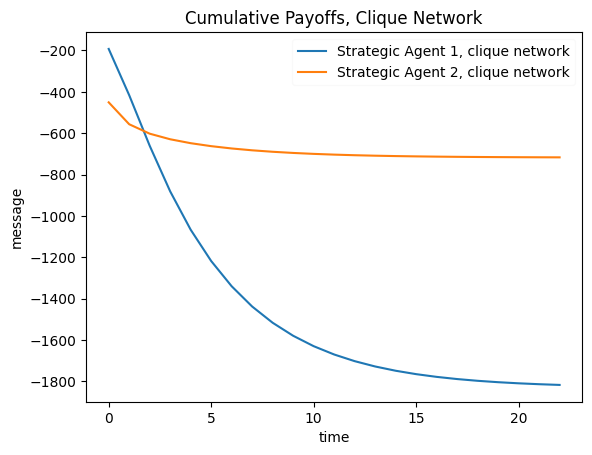

In [38]:
plt.plot(range(len(payoffs_4_2[0])), [payoffs_4_2[0][j] for j in range(len(payoffs_4_2[0]))], label = f"Strategic Agent 1, clique network")
plt.plot(range(len(payoffs_4_2[1])), [payoffs_4_2[1][j] for j in range(len(payoffs_4_2[1]))], label = f"Strategic Agent 2, clique network")

plt.xlabel("time")
plt.ylabel("message")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()